# Example notebook

> Time series classification with [tsai](). Papersweep will call this notebook and run it with multiple times with different parameters of the dataset and the architecture

In [ ]:
# papermill parameters (this cell is tagged as 'parameters' in Jupyter)
install_deps = True
stable = True # True: latest version, False: stable version

In [ ]:
import sys
ISCOLAB = 'google.colab' in sys.modules
if ISCOLAB or install_deps:
    if stable: 
        !pip install tsai -q
    else:
        !pip install git+https://github.com/timeseriesAI/tsai.git -q
    
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
tsai       : 0.2.8
fastai     : 2.1.8
fastcore   : 1.3.10
torch      : 1.7.0


In [ ]:
import wandb
from fastai.callback.wandb import *

In [ ]:
wandb.init()

wandb: Offline run mode, not syncing to the cloud.
wandb: W&B syncing is set to `offline` in this directory.  Run `wandb online` to enable cloud syncing.


AttributeError: 'NoneType' object has no attribute 'entity'

WandbCallback requires use of "SaveModelCallback" to log best model
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> tuple index out of range


epoch,train_loss,valid_loss,accuracy,time
0,1.841364,1.823326,0.266667,00:00
1,1.782366,2.426759,0.183333,00:00
2,1.575404,2.052458,0.294444,00:00
3,1.356153,1.653458,0.433333,00:00
4,1.199593,1.297879,0.511111,00:00


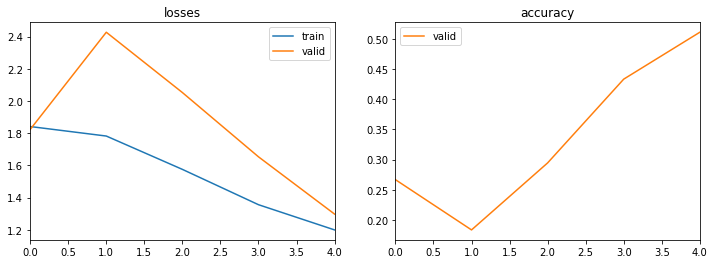

In [ ]:
wandb.config.dsid = ifnone(wandb.config.get('dsid'), 'NATOPS')
X, y, splits = get_UCR_data(wandb.config.dsid, return_split=False)
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=[TSStandardize()], num_workers=0)
wandb.config.arch = ifnone(wandb.config.get('arch'), 'InceptionTime')
k = {}
model = create_model(eval(wandb.config.arch), dls=dls, **k)
learn = Learner(dls, model, metrics=accuracy)
learn.fit_one_cycle(5, lr_max=1e-3, cbs=[WandbCallback()])
learn.recorder.plot_metrics()